# Salinity change in the IAF meltwater simulation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41049,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:41763,Total threads: 4
Dashboard: /proxy/32867/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:35899,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'
iaf_melt = '01deg_jra55v140_iaf_cycle4_MWpert'

start_time='1979-01-01'
end_time='2018-12-31'

lat_slice  = slice(-80,-59)

In [8]:
# test for Taimoor:

lat_slice  = slice(-80,-59)

psi = cc.querying.getvar(control,'ty_trans_rho',master_session, start_time = start_time, end_time=end_time)
psi = psi.sel(time=slice(start_time,end_time)).sel(grid_yu_ocean=lat_slice)
psi = psi.sum('grid_xt_ocean')
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
psi_avg.load()

<xarray.DataArray 'ty_trans_rho' (potrho: 160, grid_yu_ocean: 484)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.6045600e+08, -3.6302022e+08, -3.6556099e+08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.6045600e+08, -3.6302022e+08, -3.6556099e+08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.6045600e+08, -3.6302022e+08, -3.6556099e+08],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.06 -59.01
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

In [9]:
psi

,Array,Chunk
Bytes,141.80 MiB,21.09 kiB
Shape,"(480, 160, 484)","(1, 40, 135)"
Count,971 Graph Layers,7680 Chunks
Type,float32,numpy.ndarray


In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

## Map of bottom salinity anomaly:

In [11]:
# use final decade:
start_time='2009-01-01'
end_time='2018-12-31'

temp_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_melt = temp_melt.mean('time')
temp_melt = temp_melt.load()

In [12]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_melt = temp_melt.where(depth_array.st_ocean >= max_depth)
bottom_temp_melt = bottom_temp_melt.sum(dim = 'st_ocean')
bottom_temp_melt = bottom_temp_melt.load()


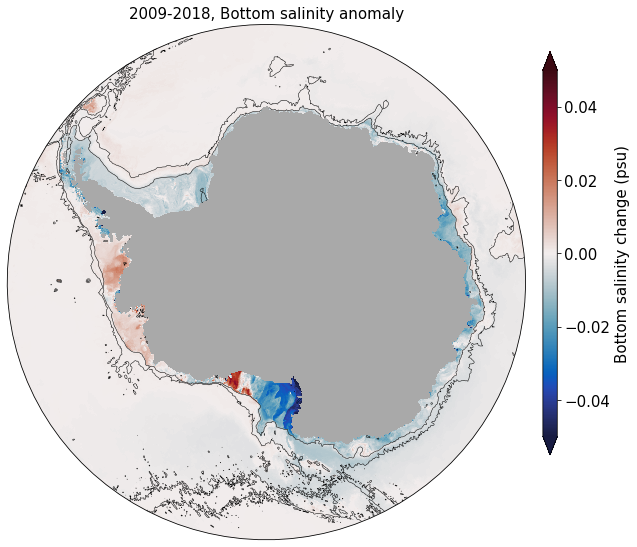

In [13]:
scale_max = .05

fig  = plt.figure(1, figsize = (8,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.9, .9],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_melt-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('2009-2018, Bottom salinity anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salinity change (psu)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## Map of SSS anomaly:

In [14]:
# use final decade:
start_time='2009-01-01'
end_time='2018-12-31'

temp_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')
temp_con = temp_con.mean('time')
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')
temp_melt = temp_melt.mean('time')
temp_melt = temp_melt.load()

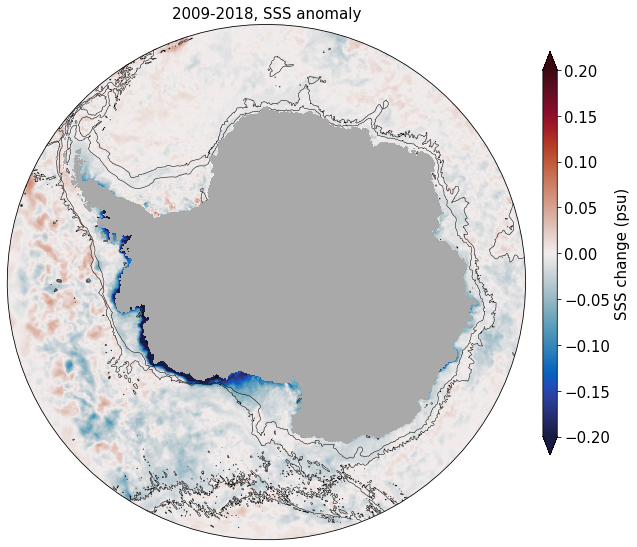

In [16]:
scale_max = .2

fig  = plt.figure(1, figsize = (8,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.9, .9],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(temp_con.xt_ocean, temp_con.yt_ocean, temp_melt-temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('2009-2018, SSS anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'SSS change (psu)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## Map of 500m salinity anomaly:

In [17]:
# use final decade:
start_time='2009-01-01'
end_time='2018-12-31'

temp_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=500,method='nearest')
temp_con = temp_con.mean('time')
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=500,method='nearest')
temp_melt = temp_melt.mean('time')
temp_melt = temp_melt.load()

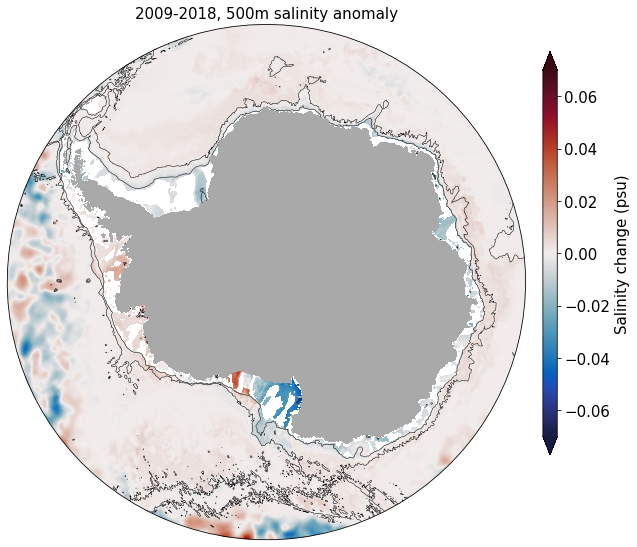

In [20]:
scale_max = .07

fig  = plt.figure(1, figsize = (8,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.9, .9],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(temp_con.xt_ocean, temp_con.yt_ocean, temp_melt-temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('2009-2018, 500m salinity anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salinity change (psu)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## Timeseries at 500m salinity in Ross:

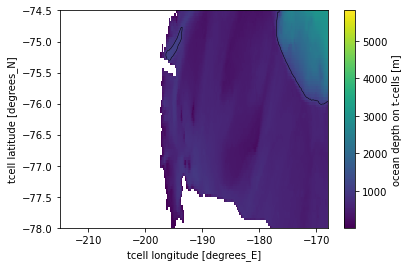

In [23]:
# first check region:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht.plot()
plt.xlim(-195-20,-188+20)
plt.ylim(-78,-76.5+2)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.5)

lat_slice  = slice(-78,-76.5)
lon_slice  = slice(-195,-188)

In [24]:
# whole time period:
start_time='1979-01-01'
end_time='2018-12-31'

# 500m slice

temp_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=500,method='nearest')
# area and depth averaging in AAB (volume contains region mask):
temp_con = (temp_con).mean('xt_ocean').mean('yt_ocean')
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=500,method='nearest')
temp_melt = (temp_melt).mean('xt_ocean').mean('yt_ocean')
temp_melt = temp_melt.load()

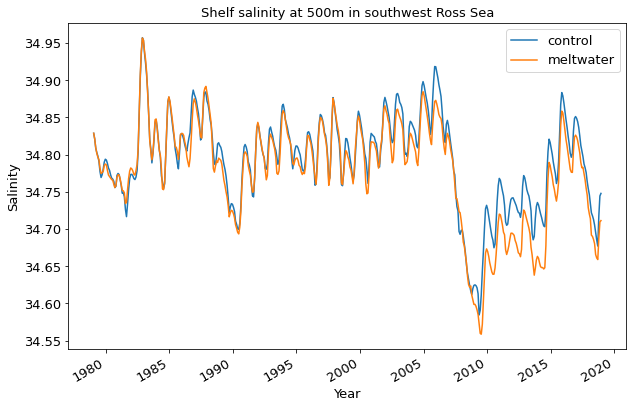

2022-09-01 14:07:45,220 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 14:07:45,220 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 14:07:45,381 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,551 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,556 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,560 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,707 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,724 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:45,825 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:46,121 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:46,128 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:46,194 - distributed.nanny - WARNING - Restarting worker
2022-09-01 14:07:46,256 - distributed.nanny - WARNING - Restarting worker
2022-09-01 1

In [25]:
fontsize=13

plt.figure(figsize=(10,6))

temp_con.plot(label='control')
temp_melt.plot(label='meltwater')
plt.legend(fontsize=fontsize)
plt.title('Shelf salinity at 500m in southwest Ross Sea',fontsize=fontsize)
plt.ylabel('Salinity',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

## Timeseries of abyssal salinity in Australian Antarctic Basin:

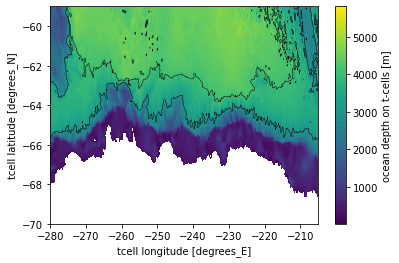

In [44]:
# first check region:

ht.plot()
plt.xlim(-280,-205)
plt.ylim(-70,-59)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[3000,4000],colors='k',linewidths=0.5)

lat_slice  = slice(-66,-59)
lon_slice  = slice(-280,-205)

In [45]:
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(control,'xt_ocean' , master_session,n=1)
yt_ocean = cc.querying.getvar(control,'yt_ocean' , master_session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
xt_ocean = xt_ocean.sel(xt_ocean=lon_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [46]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session,n=1)
area_t = area_t.where(ht>4000)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

volume = area_t*thickness
volume = volume.load()
volume_sum = volume.sum()
volume_sum = volume_sum.load()

In [47]:
# whole time period:
start_time='1979-01-01'
end_time='2018-12-31'

# average below 4000m:
depth_slice  = slice(4000,6000)

temp_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)
# area and depth averaging in AAB (volume contains region mask):
temp_con = (temp_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)
temp_melt = (temp_melt*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_melt = temp_melt.load()

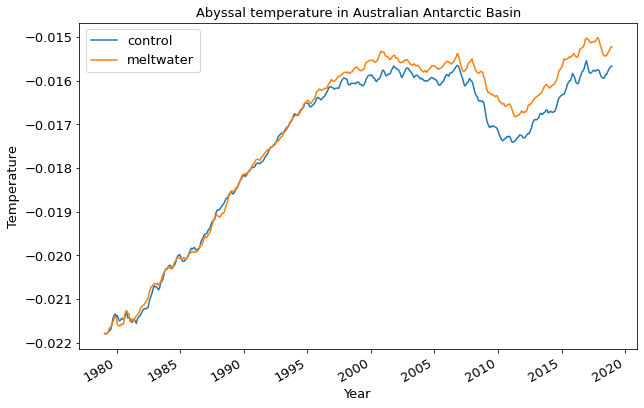

2022-08-17 18:53:48,580 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:48,702 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:48,834 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,171 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,271 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,371 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,378 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,603 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,607 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,755 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,763 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,844 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:49,935 - distributed.nanny - WARNING - Restarting worker
2022-08-17 18:53:50,079 - distributed.

In [49]:
fontsize=13

plt.figure(figsize=(10,6))

temp_con.plot(label='control')
temp_melt.plot(label='meltwater')
plt.legend(fontsize=fontsize)
plt.title('Abyssal salinity in Australian Antarctic Basin',fontsize=fontsize)
plt.ylabel('Salinity',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)